# Demystifying Machine Learning 
## Using  Local Interpretable Model-Agnostic Explanations (LIME)

by [Alejandro Correa Bahnsen](http://www.albahnsen.com/)

Machine learning models are often dismissed on the grounds of lack of interpretability. There is a popular story about modern algorithms that goes as follows: Simple linear statistical models such as logistic regression yield to interpretable models, on the other hand, advanced models such as random forest or deep neural networks are black boxes. Meaning that it is nearly impossible to understand how a model is making a prediction. 

<center>
<img src="figures/black-box.PNG" style="width: 300px;" align="middle">
</center>

The infosec industry is very used to rules, blacklisting, fingerprints and indicators of compromise so explaining why an alert went off is easy and natural. In contrast, machine learning models are able to identify complex nonlinear patterns in large data sets, extrapolate answers and make predictions based on non-trivial compositions that make it nearly impossible to get a feeling for its inner workings.

Then, if I can use simple expert rules, or regression/decision tree models that are interpretable, why should I use non-interpretable models? Well, because complex machine learning models are much more powerful. 

For example, in the next figure I’m showing the implicit tradeoff between model performance, measured in accuracy, and model complexity, measured in number of parameters. This is built using the common [MINST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/), where the objective is to identify which number was written by looking only at the pixel values of each image.


<center>
<img src="figures/complexity.png" style="width: 600px;" align="middle">
</center>
* [Notebook to create the above plot](http://nbviewer.jupyter.org/github/albahnsen/Talk_Demystifying_Machine_Learning/blob/master/figures/Create_Model_Complexity_Figure.ipynb)

As we can see, as a general rule, the more complex the model the higher its performance. In this case, using a simple interpretable decision tree yields an accuracy of 86%, on the other hand a convolutional neural network has an accuracy of 99.3%, however, it must train more than a million parameters, compared with only 1,700 of the decision tree. 

Big efforts are being invested in finding ways to explain the output of machine learning models. Just over a couple months ago, a novel method [LIME](http://arxiv.org/abs/1602.04938) was presented during the 2016 ACM's Conference on Knowledge Discovery and Data Mining. LIME stands for Local Interpretable Model-agnostic Explanations, and its objective is to explain the result from any classifier so that a human can understand individual predictions.


<center>
<img src="https://d3ansictanv2wj.cloudfront.net/figure1-a9533a3fb9bb9ace6ee96b4cdc9b6bcb.jpg" style="width: 800px;" align="middle">
</center>
* [Source](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime)


The LIME algorithm approximates the underlying model with an interpretable one. This is done by learning on perturbations of the original example, and training a sparse linear model  in the nearest neighborhood around the target instance. Let's see how that is done with this example. 

An *interpretable representation* is a point in a space whose dimensions can be interpreted by a human.  Practically speaking, this paper uses small binary vectors of simple features.  For instance, a text classifier might use a large space of word embeddings and ngrams as its input representation, while the explanation would use the presence or absence of a handful of particular words as an interpretable representation.  The paper specifically focuses on finding sparse linear models as explanations, but notes that the same technique could be used to generate decision trees or falling rule lists as interpretable models.  All of these are assumed to be over a domain \\( \\{0,1\\}^{d'} \\) of interpretable components -- i.e. a reasonably small number of human interpretable features.

LIME frames the search for an interpretable explanation as an optimization problem.  Given a set \\({G}\\) of potentially interpretable models, we need a measure \\( \mathcal{L}(f,g,x) \\) of how poorly the interpretable model \\( g \in G \\) approximates the original model \\(f\\) for point \\(x\\) -- this is the loss function.  We also need some measure \\( \Omega(g) \\) of the complexity of the model (e.g. the depth of a decision tree).  We then pick a model which minimizes both of these

\\[
  \xi(x) = argmin_{g \in G} \mathcal{L}(f,g,x) + \Omega(g)
\\]


For a given example in the original input space \\( x \in R^d \\), we want to learn a locally faithful linear model in a relatively small feature space.  The intuition is shown in the following diagram.

<center>
<img src="https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png" style="width: 500px;" align="middle">
</center>
* [Source](https://github.com/marcotcr/lime)


In the figure, the black-box complex decision function is represented by the blue/pink background. As expected there is no easy way to generalize this non-linear model. However, if we look locally, we can extract linear explanations. LIME, first select the nearest neighbors to the prediction that we want to explain. These nearest neighbours are represented by the big crosses and circles. Afterwards, we can fit an explainable linear model using only the selected instances, and use the coefficients of the linear model to explain a particular prediction. The bold red cross represents the instance being explained.  The pink blob in the background represents the complex model \\( f \\).  The dashed line is the learned linear model \\( g \\) which will be used as an explanation.  This function is locally faithful to \\( f \\) but globally does not behave at all similarly.

The general approach is to search for the optimal explanatory model \\( g(x) \\) by sampling in the vecinity of the example x.  We then search the space of potential explanatory models for one which optimizes the objective function \\( \mathcal{L} + \Omega \\).

The paper focuses on a couple concrete implementations of this approach.  For text classification, the interpretable representation is a bag of words of maximum size \\( K \\).  For image recognition, the interpretable representation is a binary vector of "super-pixels" of maximum size \\( K \\).  The K features are selected first, using a regression technique, and then the weights of the linear model \\( g \\) are selected using a least-squares regression, weighted by the distance between the sample \\( z \\) and the original point \\( x \\). 

* Starting from a point \\(x\\) in the original input space map it to a corresponding point \\(x' \in \\{0,1\\}^{d'} \\) in the interpretable space.
* Then take random samples \\( z' \\) around \\( x' \\)
* Map each sample \\(z'\\) back to a point \\(z\\) in the original space and get the prediction \\( f(z) \\) using the original global model.
* Calculate the distance \\( \Pi_x(z) \\) between the sample point and the original point
* Fit the weights of \\(g\\) to minimize the error \\(f(z) - g(z')\\) between the explanatory model and the global model for the set of perturbed examples, weighted by the distance of the perturbed example from the original example.

[LIME summary from michaelrkytch](http://michaelrkytch.github.io/papers/machine%20learning/2016/07/12/lime-explainability.html)

I know this sounds way to confusing, but allow me to show an example of using LIME to explain the prediction of a Phishing URLs classifier model.

# Case Study: URL phishing detection

Phishing, by definition, is the act of defrauding an online user in order to obtain personal information by posing as a trustworthy institution or entity. Users usually have a hard time differentiating between legitimate and malicious sites because they are made to look exactly the same. Therefore, there is a need to create better tools to combat attackers.

Phishing attacks can be launched from anywhere in the
world by people with little to no technical skills at insignificant
costs. Organizations trying to protect their users from these
attacks have a hard time dealing with massive amount of
emerging sites which must be identified and labeled either as
malicious or harmless before users access them.

Being able to determine the maliciousness of a website by
just looking at its URL provides a major strategic advantage,
since the number of victims can be reduced to nearly zero
while minimizing operational efforts by avoiding massive use
of more complex methods such content analysis.

#### Data

To evaluate create a  phishing classifier, lets use a corpus of one
million phishing URLs extracted from Phishtank and one
million harmless URLs from the CommonCrawl. (Actually a small sample here)


In [1]:
import pandas as pd
import zipfile
with zipfile.ZipFile('phishing.csv.zip', 'r') as z:
    f = z.open('phishing.csv')
    data = pd.read_csv(f, index_col=False)

In [2]:
data.head()

,url,phishing
0,http://www.subalipack.com/contact/images/sampl...,1
1,http://fasc.maximecapellot-gypsyjazz-ensemble....,1
2,http://theotheragency.com/confirmer/confirmer-...,1
3,http://aaalandscaping.com/components/com_smart...,1
4,http://paypal.com.confirm-key-21107316126168.s...,1


In [3]:
data.tail()

,url,phishing
39995,http://www.diaperswappers.com/forum/member.php...,0
39996,http://posting.bohemian.com/northbay/Tools/Ema...,0
39997,http://www.tripadvisor.jp/Hotel_Review-g303832...,0
39998,http://www.baylor.edu/content/services/downloa...,0
39999,http://www.phinfever.com/forums/viewtopic.php?...,0


In [4]:
data.phishing.value_counts()

1    20000
0    20000
Name: phishing, dtype: int64

#### Creating features

In [32]:
data.url[data.phishing==1].sample(10, random_state=1).tolist()

['http://dothan.com.co/gold/austspark/index.htm\n',
 'http://78.142.63.63/%7Enetsysco/process/fc1d9c7ea4773b7ff90925c2902cb5f2\n',
 'http://verify95.5gbfree.com/coverme2010/\n',
 'http://www.racom.com/uploads/productscat/bookmark/ii.php?.rand=13vqcr8bp0gud&cbcxt=mai&email=abuse@tradinghouse.ca\n',
 'http://www.cleanenergytci.com/components/update.logon.l3an7lofamerica/2342343234532534546347677898765432876543345687656543876/\n',
 'http://209.148.89.163/-/santander.co.uk/weblegn/AccountLogin.php\n',
 'http://senevi.com/confirmation/\n',
 'http://www.hellenkeller.cl/tmp/new/noticias/Modulo_de_Atualizacao_Bradesco/index2.php?id=PSO1AM04L3Q6PSBNVJ82QUCO0L5GBSY2KM2U9BYUEO14HCRDVZEMTRB3DGJO9HPT4ROC4M8HA8LRJD5FCJ27AD0NTSC3A3VDUJQX6XFG519OED4RW6Y8J8VC19EAAAO5UF21CHGHIP7W4AO1GM8ZU4BUBQ6L2UQVARVM\n',
 'http://internet-sicherheit.co/de/konflikt/src%3Dde/AZ00276ZZ75/we%3Dhs_0_2/sicherheit/konto_verifizieren/verifizierung.php\n',
 'http://alen.co/docs/cleaner\n']

Contain any of the following:
* https
* login
* .php
* .html
* @
* sign
* ?

In [6]:
keywords = ['https', 'login', '.php', '.html', '@', 'sign']
for keyword in keywords:
    data['keyword_' + keyword] = data.url.str.contains(keyword).astype(int)

* Length of the url
* Length of domain
* is IP?
* Number of .com

In [7]:
data['length'] = data.url.str.len() - 2
domain = data.url.str.split('/', expand=True).iloc[:, 2]
data['length_domain'] = domain.str.len()

In [8]:
domain.head(12)

0                                    www.subalipack.com
1             fasc.maximecapellot-gypsyjazz-ensemble.nl
2                                    theotheragency.com
3                                    aaalandscaping.com
4     paypal.com.confirm-key-21107316126168.securepp...
5                              lcthomasdeiriarte.edu.co
6                                       livetoshare.org
7                                            www.i-m.co
8                                     manuelfernando.co
9                                www.bladesmithnews.com
10                                      www.rasbaek.com
11                                      199.231.190.160
Name: 2, dtype: object

In [9]:
data['isIP'] = (domain.str.replace('.', '') * 1).str.isnumeric().astype(int)

In [10]:
data['count_com'] = data.url.str.count('com')

In [31]:
data.sample(10, random_state=4)

,url,phishing,keyword_https,keyword_login,keyword_.php,keyword_.html,keyword_@,keyword_sign,lenght,lenght_domain,isIP,count_com
28607,http://pennstatehershey.org/web/ibd/home/event...,0,0,0,0,0,0,0,80,20,0,0
3689,http://guiadesanborja.com/multiprinter/muestra...,1,0,1,1,0,0,0,81,18,0,1
6405,http://paranaibaweb.com/faleconosco/accounting...,1,0,0,0,1,0,0,65,16,0,1
35355,http://courts.delaware.gov/Jury%20Services/Hel...,0,0,0,0,0,0,0,94,19,0,0
16520,http://erpa.co/tmp/getproductrequest.htm\n,1,0,0,0,0,0,0,39,7,0,0
16196,http://pulapulapipoca.com/components/com_media...,1,0,1,1,0,0,0,239,18,0,4
3810,http://www.dag.or.kr/zboard/icon/visa/img/Atua...,1,0,0,0,0,0,0,62,13,0,0
3005,http://www.amazingdressup.com/wp-content/theme...,1,0,0,0,1,0,0,94,22,0,1
9003,http://web.indosuksesfutures.com/content_file/...,1,0,0,0,0,0,0,80,25,0,1
34704,http://www.nutritionaltree.com/subcat.aspx?cid...,0,0,0,0,0,0,0,69,23,0,1


#### Create a model

In [12]:
X = data.drop(['url', 'phishing'], axis=1)
y = data.phishing

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [14]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=100)

In [15]:
cross_val_score(clf, X, y, cv=10)

array([ 0.8065 ,  0.81025,  0.804  ,  0.789  ,  0.80325,  0.8145 ,
        0.8015 ,  0.80775,  0.80225,  0.79175])

In [16]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

#### Feature Importances

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [19]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

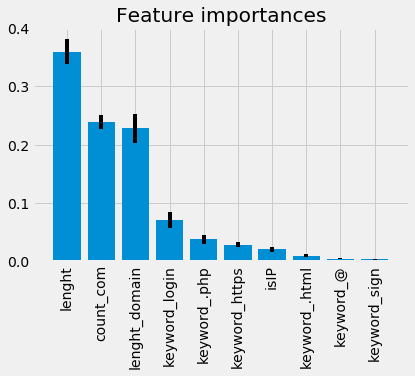

In [30]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns.values[indices], rotation='90')
plt.xlim([-1, X.shape[1]])
plt.show()

Feature importance is an interesting tool to evaluate in a general way which features are more important during training. But it does not gives any insight regarding the feature importance of a given individual prediction.

## Explaining individual predictions using LIME

First install lime using

```pip install lime```

In [33]:
import lime
import lime.lime_tabular

In [41]:
explainer = lime.lime_tabular.LimeTabularExplainer(X.values ,feature_names = X.columns.values,class_names=['ham','phish'],
                                                   categorical_features=[0, 1, 2, 3, 4, 5, 8], kernel_width=3)

/home/al/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


#### Function to explain a single instance using LIME

In [112]:
def explain_instance(X_test):
    if X_test.phishing.values == 1:
        print("Phishing URL")
    else:
        print("Legitimate URL")
    print(X_test.url.values[0])
    y_pred_proba = clf.predict_proba(X_test.drop(['url', 'phishing'], axis=1))
    print("Predicted Probabilites: ", y_pred_proba[0])

    # Explain prediction
    predict_fn = lambda x: clf.predict_proba(x).astype(float)
    exp = explainer.explain_instance(X_test.drop(['url', 'phishing'], axis=1).values[0], predict_fn, num_features=5)

    # Organize explinations
    temp = pd.DataFrame(exp.as_list())
    vals = temp.iloc[:, 1].tolist()
    features = temp.iloc[:, 0].tolist()
    loc = np.arange(temp.shape[0])[::-1]

    # Plot
    print()
    print("Feature importances:")
    fig, ax = plt.subplots(figsize=(6,4))
    # Plot positive impact features
    plt.barh(loc, [max(val, 0) for val in vals], height=0.5, color='r')
    # Plot negative impact features
    plt.barh(loc, [min(val, 0) for val in vals], height=0.5)

    # Plot to fix range
    plt.barh([0, 0], [-np.abs(vals).max()*1.2, np.abs(vals).max()*1.2], alpha=0)


    # Add labels
    for label, x, y in zip(features, np.zeros(loc.shape[0]), loc):
        if vals[features.index(label)] > 0:
            plt.annotate(label, xy = (x, y), xytext = (5, 27),
                         textcoords = 'offset points', ha = 'left', va = 'top')
        else:
            plt.annotate(label, xy = (x, y), xytext = (-5, 27),
                         textcoords = 'offset points', ha = 'right', va = 'top')
    plt.yticks([])      
    plt.xticks([0], [''])
    plt.annotate('HAM', xy = (np.min(vals)*0.5, max(loc)+1.05), xytext = (0, 0),
                 textcoords = 'offset points', ha = 'right', va = 'top')
    plt.title('      HAM                   Phish                ', y=1.13)
    plt.show()

Test with a random phishing URL

Phishing URL
http://login.paypal.com.convexcentral.com/Update/ab770f624342b07b71e56c1bae5d9bcb/

Predicted Probabilites:  [ 0.  1.]

Feature importances:


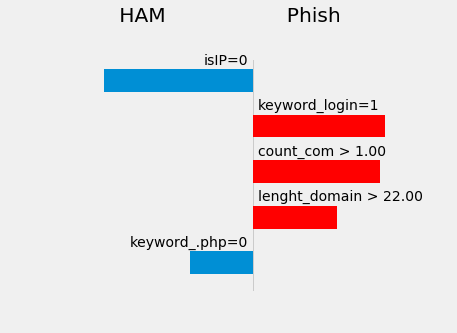

In [114]:
explain_instance(data.query('phishing == 1').sample(1, random_state=7))

Test with a random legitimate URL

Legitimate URL
http://www.redeyechicago.com/entertainment/tv/redeye-banshee-ivana-milicevic-interview-20140120-story.html

Predicted Probabilites:  [ 0.9655  0.0345]

Feature importances:


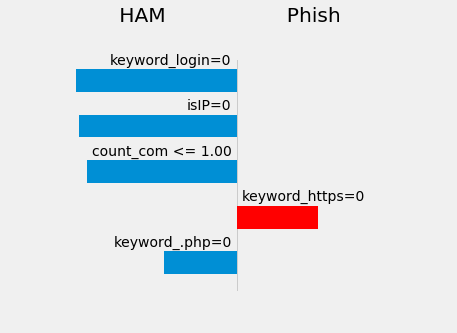

In [99]:
explain_instance(data.query('phishing == 0').sample(1, random_state=1))

# Conclusion

With LIME we can actually understand how the classifier is making predictions without having to see the millions of parameters that the model has. In the first example, we’re looking at phishing URL’s from Phishtank, and see why the classifier is assigning both a very high probability of phish. On the other hand, we look at a ham URL, we see that the URL does not contain suspicious words, the length of the subdomain is short and it is not an IP. These indicators are the ones that the classifer uses in order to give this URL a low phishing probability.


This method presents a very compelling paradigm for producing example-based explanations of complex classifiers which can truly be useful in building trust in specific predictions and in selecting and tuning models without deep ML expertise. I have worked on several projects in the past which eschewed advanced ML algorithms due to the need for explainability. The type of technique explored here point towards a path where we can utilize the power of complex predictive models while still providing useful explanations.